In [21]:
!pip3 install torch torchvision scikit-learn
 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import numpy as np
import time

print("PyTorch:", torch.__version__)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

PyTorch: 2.9.0
Using device: mps


In [23]:
# Initial transform: resize + tensor only
base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_raw = torchvision.datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=base_transform
)

print("Train size:", len(train_raw))  # should be 5000

# Compute mean and std over training data
loader_tmp = DataLoader(train_raw, batch_size=256, shuffle=False)

mean = 0.0
std = 0.0
n_samples = 0

for imgs, _ in loader_tmp:
    batch_size = imgs.size(0)
    imgs = imgs.view(batch_size, imgs.size(1), -1)  # (B, C, H*W)
    mean += imgs.mean(2).sum(0)
    std  += imgs.std(2).sum(0)
    n_samples += batch_size

mean /= n_samples
std /= n_samples

print("Mean:", mean)
print("Std:", std)

Train size: 5000
Mean: tensor([0.4468, 0.4399, 0.4068])
Std: tensor([0.2027, 0.2003, 0.2028])


In [24]:
# Final transform with normalization to zero-mean, unit-variance
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_full = torchvision.datasets.STL10(
    root="./data",
    split="train",
    download=True,
    transform=transform
)

test_full = torchvision.datasets.STL10(
    root="./data",
    split="test",
    download=False,
    transform=transform
)

print("Train size:", len(train_full))  # 5000
print("Test size:", len(test_full))    # 8000

# Split test_full -> 300 val, 500 test, rest unused
n_total_test = len(test_full)
assert n_total_test == 8000

val_size = 300
test_size = 500
remainder = n_total_test - (val_size + test_size)  # 7200

val_subset, test_subset, _ = random_split(
    test_full,
    [val_size, test_size, remainder]
)

print("Val size:", len(val_subset))
print("Final test size:", len(test_subset))

# Dataloaders
BATCH_SIZE = 128

train_loader = DataLoader(train_full, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

Train size: 5000
Test size: 8000
Val size: 300
Final test size: 500


In [25]:
class LeNet5_BN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.bn1   = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.pool  = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1   = nn.Linear(16*5*5, 120)
        self.bn3   = nn.BatchNorm1d(120)
        
        self.fc2   = nn.Linear(120, 84)
        self.bn4   = nn.BatchNorm1d(84)
        
        self.fc3   = nn.Linear(84, 10)  # logits for 10 classes

    def forward(self, x):
        # Conv block 1: Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Conv block 2: Conv -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC block 1: FC -> BN -> ReLU
        x = F.relu(self.bn3(self.fc1(x)))
        
        # FC block 2: FC -> BN -> ReLU
        x = F.relu(self.bn4(self.fc2(x)))
        
        # Output (no softmax, CrossEntropyLoss handles that)
        x = self.fc3(x)
        return x
    

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = LeNet5_BN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [26]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    n = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            n += y.size(0)
    
    return total_loss / n, correct / n

In [27]:
EPOCHS = 100

train_losses = []      # per batch
val_losses = []        # one every 5 epochs
val_accuracies = []    # one every 5 epochs
val_check_epochs = []  # which epoch each val corresponds to

for epoch in range(EPOCHS):
    model.train()
    epoch_start = time.time()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        # Log training loss each batch
        train_losses.append(loss.item())
    
    # Step LR scheduler
    scheduler.step()
    
    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        v_loss, v_acc = evaluate(model, val_loader)
        val_losses.append(v_loss)
        val_accuracies.append(v_acc)
        val_check_epochs.append(epoch + 1)
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f} | "
              f"time: {time.time()-epoch_start:.1f}s")

Epoch   5/100 | Val Loss: 1.4508 | Val Acc: 0.4467 | LR: 0.001000 | time: 1.2s
Epoch  10/100 | Val Loss: 1.6739 | Val Acc: 0.4433 | LR: 0.001000 | time: 1.0s
Epoch  15/100 | Val Loss: 2.0416 | Val Acc: 0.4333 | LR: 0.001000 | time: 1.0s
Epoch  20/100 | Val Loss: 2.1166 | Val Acc: 0.4533 | LR: 0.000500 | time: 1.1s
Epoch  25/100 | Val Loss: 2.1667 | Val Acc: 0.4867 | LR: 0.000500 | time: 1.2s
Epoch  30/100 | Val Loss: 2.1586 | Val Acc: 0.4867 | LR: 0.000500 | time: 1.0s
Epoch  35/100 | Val Loss: 2.3628 | Val Acc: 0.4667 | LR: 0.000500 | time: 1.0s
Epoch  40/100 | Val Loss: 2.4359 | Val Acc: 0.4833 | LR: 0.000250 | time: 1.1s
Epoch  45/100 | Val Loss: 2.5937 | Val Acc: 0.4933 | LR: 0.000250 | time: 1.0s
Epoch  50/100 | Val Loss: 2.5696 | Val Acc: 0.4767 | LR: 0.000250 | time: 1.1s
Epoch  55/100 | Val Loss: 2.5423 | Val Acc: 0.4667 | LR: 0.000250 | time: 1.1s
Epoch  60/100 | Val Loss: 2.5788 | Val Acc: 0.4900 | LR: 0.000125 | time: 1.1s
Epoch  65/100 | Val Loss: 2.7385 | Val Acc: 0.4633 |

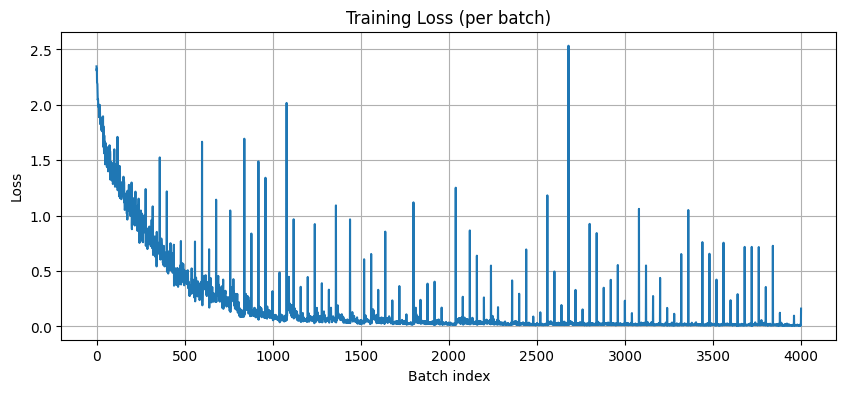

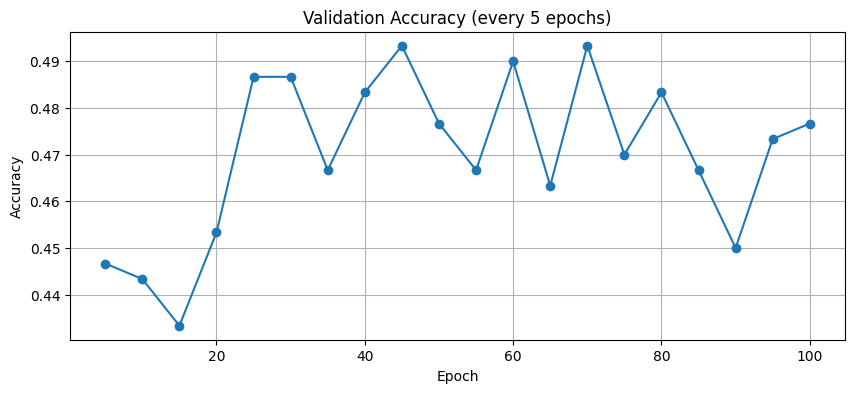

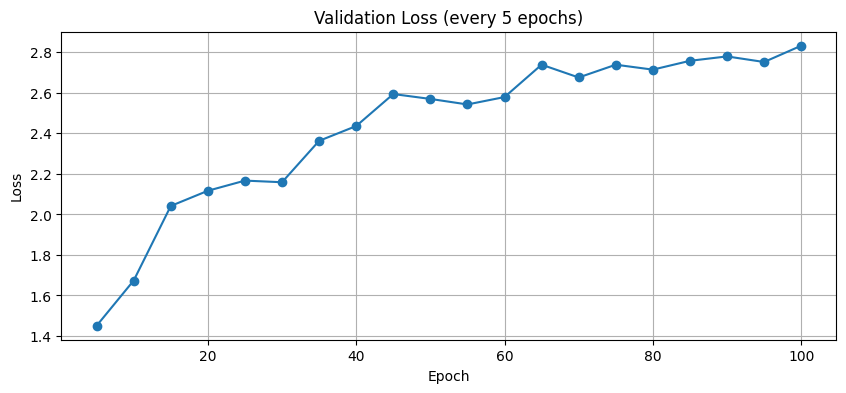

In [28]:
# Training loss per batch
plt.figure(figsize=(10,4))
plt.plot(train_losses)
plt.title("Training Loss (per batch)")
plt.xlabel("Batch index")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Validation accuracy over epochs
plt.figure(figsize=(10,4))
plt.plot(val_check_epochs, val_accuracies, marker='o')
plt.title("Validation Accuracy (every 5 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Validation loss over epochs
plt.figure(figsize=(10,4))
plt.plot(val_check_epochs, val_losses, marker='o')
plt.title("Validation Loss (every 5 epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [29]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 2.8710
Test accuracy: 0.4520


In [30]:
# Get all predictions and labels on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[34  0  1  3  1  3  2  0  6  5]
 [ 2 17  0  8  8  5  4  3  1  3]
 [ 1  1 26  1  2  1  0  0  1  7]
 [ 1  6  1 16 10  3  2  5  3  1]
 [ 3  8  0  2 23  3  5  1  1  1]
 [ 0  6  0  7  6  9 10  5  0  0]
 [ 2  3  2  3  2 10 26  5  0  2]
 [ 0  8  0 10  5  4  9 15  0  2]
 [ 4  0  0  2  1  1  0  0 33  3]
 [ 4  1 12  3  4  2  0  3  8 27]]


In [31]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer',
               'dog', 'horse', 'monkey', 'ship', 'truck']

class_correct = cm.diagonal()
class_totals = cm.sum(axis=1)
class_acc = class_correct / class_totals

for idx, (name, acc) in enumerate(zip(class_names, class_acc)):
    print(f"Class {idx} ({name:8s}): {acc:.3f}")

Class 0 (airplane): 0.618
Class 1 (bird    ): 0.333
Class 2 (car     ): 0.650
Class 3 (cat     ): 0.333
Class 4 (deer    ): 0.489
Class 5 (dog     ): 0.209
Class 6 (horse   ): 0.473
Class 7 (monkey  ): 0.283
Class 8 (ship    ): 0.750
Class 9 (truck   ): 0.422


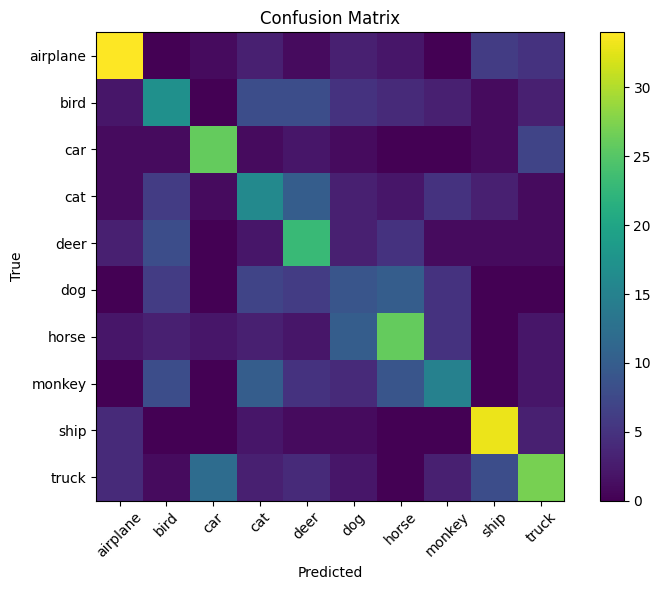

In [32]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()